In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
meg = pd.read_csv('Meg Price History - Hoja 1.csv')
pta = pd.read_csv('PTA Price History - Hoja 1.csv')

##### Análisis de la información y limpieza

In [3]:
meg.head()

,Fecha,MEG c/lb
0,2/3/2018,"54,34"
1,9/3/2018,"54,34"
2,16/3/2018,"54,34"
3,23/3/2018,"54,34"
4,29/3/2018,"52,84"


In [4]:
pta.head()

,Fecha,PTA c/lb
0,2/3/2018,"48,18"
1,9/3/2018,"48,18"
2,16/3/2018,"48,18"
3,23/3/2018,"48,18"
4,29/3/2018,"48,01"


In [5]:
meg['Fecha']= meg['Fecha'].str.replace('/', '-')

In [6]:
pta['Fecha']= pta['Fecha'].str.replace('/', '-')

In [7]:
meg['MEG c/lb']= meg['MEG c/lb'].str.replace(',', '.')

In [8]:
pta['PTA c/lb']= pta['PTA c/lb'].str.replace(',', '.')

In [9]:
meg['MEG c/lb'] = meg['MEG c/lb'].astype('float64')

In [10]:
pta['PTA c/lb'] = pta['PTA c/lb'].astype('float64')

In [11]:
meg['Fecha'] = pd.to_datetime(meg['Fecha'])

In [12]:
pta['Fecha'] = pd.to_datetime(pta['Fecha'])

In [13]:
pta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     237 non-null    datetime64[ns]
 1   PTA c/lb  237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [14]:
meg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Fecha     237 non-null    datetime64[ns]
 1   MEG c/lb  237 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [15]:
meg = meg.set_index('Fecha')

In [16]:
pta = pta.set_index('Fecha')

In [17]:
meg.head()

,MEG c/lb
Fecha,
2018-02-03,54.34
2018-09-03,54.34
2018-03-16,54.34
2018-03-23,54.34
2018-03-29,52.84


In [18]:
pta.head()

,PTA c/lb
Fecha,
2018-02-03,48.18
2018-09-03,48.18
2018-03-16,48.18
2018-03-23,48.18
2018-03-29,48.01


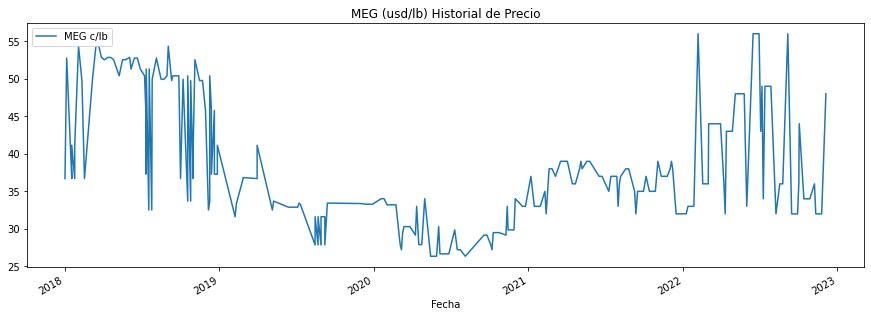

In [19]:
meg.plot(figsize=(15, 5),title='MEG (usd/lb) Historial de Precio')
plt.show()

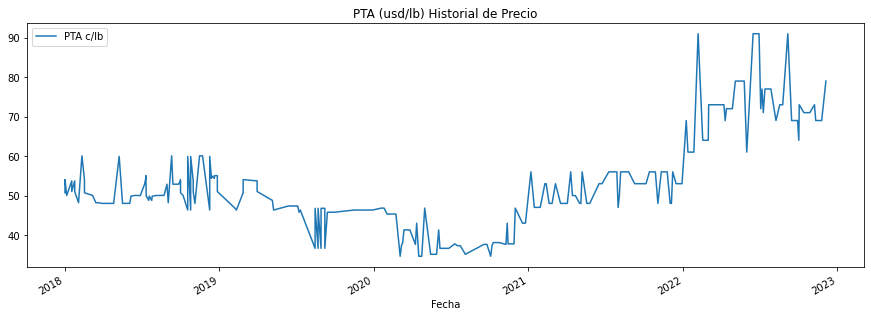

In [20]:
pta.plot(figsize=(15, 5),title='PTA (usd/lb) Historial de Precio')
plt.show()

##### Entrenamiento de los datos

In [21]:
meg1=meg.copy()

In [22]:
pta1=pta.copy()

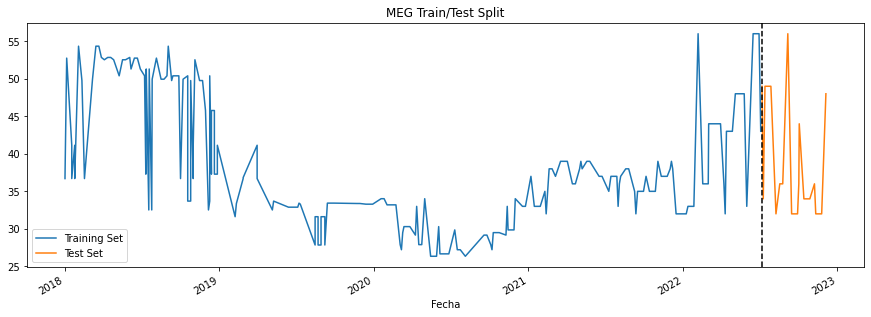

In [23]:
meg1_train = meg1.loc[meg1.index < '07-07-2022']
meg1_test = meg1.loc[meg1.index >= '07-07-2022']

fig, ax = plt.subplots(figsize=(15, 5))
meg1_train.plot(ax=ax, label='Training Set', title='MEG Train/Test Split')
meg1_test.plot(ax=ax, label='Test Set')
ax.axvline('07-07-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

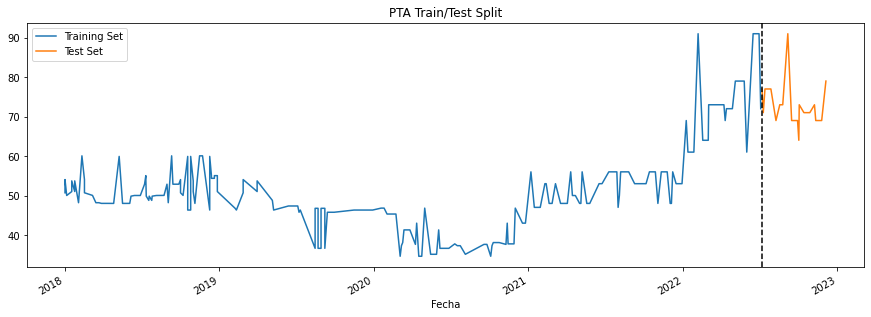

In [24]:
pta1_train = pta1.loc[pta1.index < '07-07-2022']
pta1_test = pta1.loc[pta1.index >= '07-07-2022']

fig, ax = plt.subplots(figsize=(15, 5))
pta1_train.plot(ax=ax, label='Training Set', title='PTA Train/Test Split')
pta1_test.plot(ax=ax, label='Test Set')
ax.axvline('07-07-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

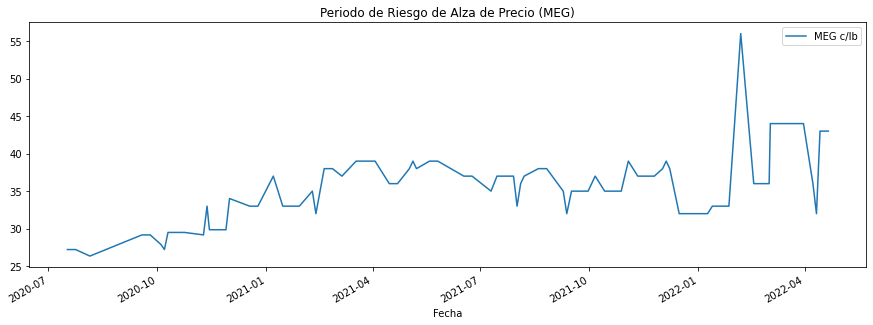

In [25]:
meg1.loc[(meg1.index > '07-11-2020') & (meg1.index < '28-04-2022')] \
    .plot(figsize=(15, 5), title='Periodo de Riesgo de Alza de Precio (MEG)')
plt.show()

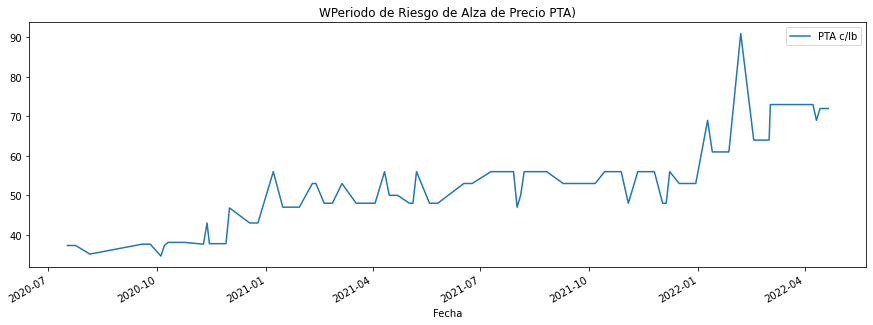

In [26]:
pta1.loc[(pta1.index > '07-11-2020') & (pta1.index < '28-04-2022')] \
    .plot(figsize=(15, 5), title='WPeriodo de Riesgo de Alza de Precio PTA)')
plt.show()

In [27]:
def create_features(meg1):
        meg1['quarter'] = meg1.index.quarter
        meg1['month'] = meg1.index.month
        meg1['year'] = meg1.index.year
        return meg1
meg1 = create_features(meg1)

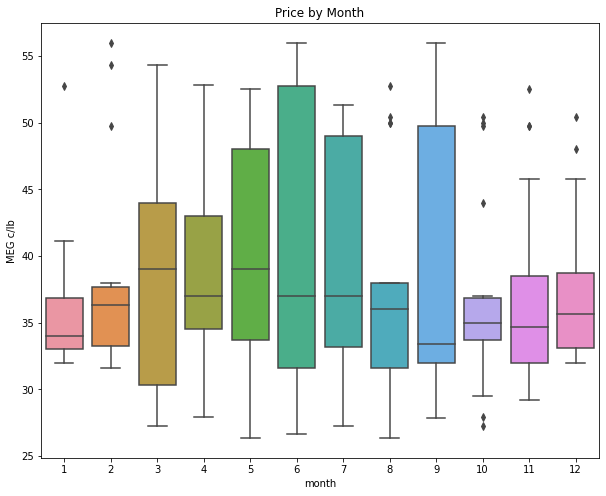

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=meg1, x='month', y='MEG c/lb')
ax.set_title('Price by Month')
plt.show()

##### Modelo

##### Modelo para MEG

In [29]:
meg1_train = create_features(meg1_train)
meg1_test = create_features(meg1_test)

FEATURES = ['quarter', 'month', 'year']
TARGET = 'MEG c/lb'

X_train = meg1_train[FEATURES]
y_train = meg1_train[TARGET]

X_test = meg1_test[FEATURES]
y_test = meg1_test[TARGET]

In [30]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:18:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:38.13667	validation_1-rmse:38.43122
[100]	validation_0-rmse:14.97282	validation_1-rmse:14.52430
[200]	validation_0-rmse:6.95777	validation_1-rmse:7.59850
[247]	validation_0-rmse:5.46682	validation_1-rmse:8.12333


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

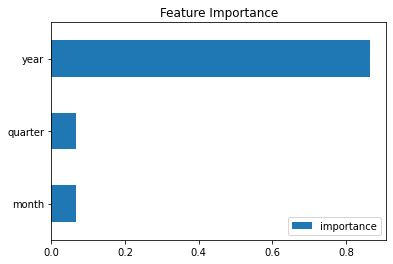

In [31]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

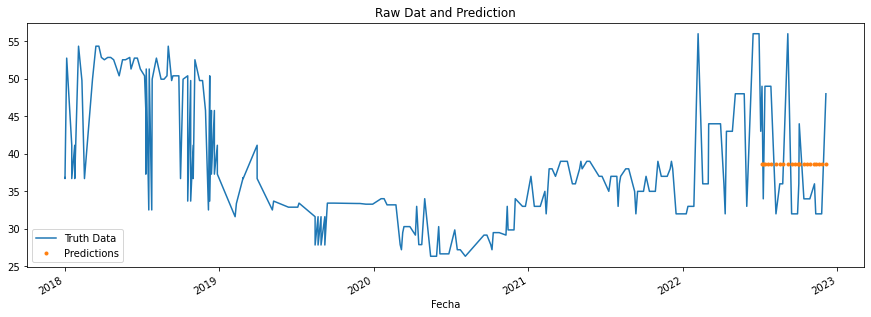

In [32]:
meg1_test['prediction'] = reg.predict(X_test)
meg1 = meg1.merge(meg1_test[['prediction']], how='left', left_index=True, right_index=True)
ax = meg1[['MEG c/lb']].plot(figsize=(15, 5))
meg1['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [33]:
score = np.sqrt(mean_squared_error(meg1_test['MEG c/lb'], meg1_test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 7.60


In [34]:
meg1_test['error'] = np.abs(meg1_test[TARGET] - meg1_test['prediction'])
meg1_test['date'] = meg1_test.index.date
meg1_test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-09-06    17.414295
2022-07-07    10.414295
2022-07-14    10.414295
2022-07-21    10.414295
2022-07-28    10.414295
2022-12-05     9.414295
2022-08-09     6.585705
2022-09-15     6.585705
2022-09-22     6.585705
2022-11-11     6.585705
Name: error, dtype: float64